In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


In [3]:
def f(x):
    return 1 / (1 + np.exp(-x))

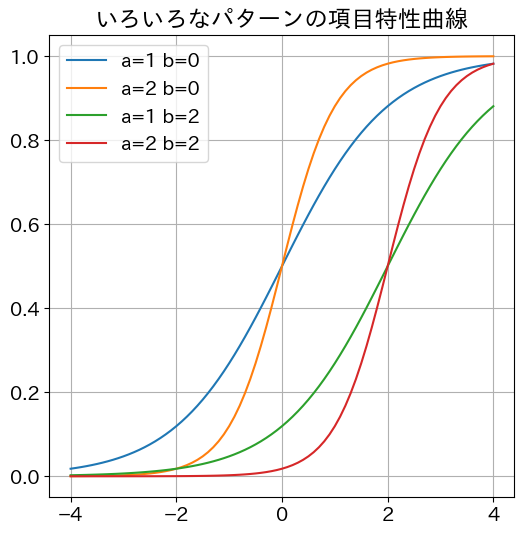

,a(識別力),b(困難度),f(1),f(2)
問題1,1.000,0.000,0.731,0.881
問題2,2.000,0.000,0.881,0.982
問題3,1.000,2.000,0.269,0.500
問題4,2.000,2.000,0.119,0.500


In [4]:
params = [[1, 0], [2, 0], [1, 2], [2, 2]]

x = np.arange(-4, 4.1, 0.1)

vals = np.zeros((0, 4))

for a, b in params:
    y = f(a * (x - b))
    y1 = f(a * (1 - b))
    y2 = f(a * (2 - b))
    vals = np.vstack([vals, [a, b, y1, y2]])
    # print(f'a={a} b={b} f(1)={y1:.02f} f(2)={y2:.02f}')
    plt.plot(x, y, label=f"a={a} b={b}")
plt.legend()
plt.title("いろいろなパターンの項目特性曲線")
plt.show()

df = pd.DataFrame(vals, columns=["a(識別力)", "b(困難度)", "f(1)", "f(2)"])
df.index = ["問題1", "問題2", "問題3", "問題4"]
display(df)

In [5]:
url = "https://github.com/makaishi2/samples/raw/main/data/irt-sample.csv"
df = pd.read_csv(url, index_col=0)

# 結果確認
display(df.head())
print(df.shape)

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0001,0,1,1,1,0,1,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,1,0,1,1,1
USER0002,1,0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0
USER0003,1,0,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
USER0004,1,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,1,1,1,0,0,0,1
USER0005,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0


(1000, 50)


In [6]:
# melt関数で横持ち形式を縦持ち形式に変換
# - df は「行＝ユーザー、列＝質問項目」のような“横持ち（wide）”データになっている想定。
# - pd.melt を使うと、各セルを
#     (user, question, response)
#   という“縦持ち（long / tidy）”形式に展開できる。
# - reset_index() をしているのは、元の index（=ユーザーIDなど）を
#   melt の id_vars として扱うために列へ降ろす目的。
response_df = pd.melt(
    df.reset_index(), id_vars="index", var_name="question", value_name="response"
)

# 列名indexをuserに変換
# - reset_index により追加された列名はデフォルトで 'index' になる。
# - ここではその列が「ユーザー識別子」を表すので、意味が伝わる 'user' にリネームしている。
response_df = response_df.rename({"index": "user"}, axis=1)

# 要素数の変化を確認
# - wide → long に変換すると、
#   行数は「元の行数 × 元の列数」程度に増えるのが通常。
# - 変換が意図通り行われたかを shape 比較でチェックしている。
print(f"元データ(df): {df.shape}")
print(f"変換後データ(response_df): {response_df.shape}\n")

# 結果確認
# - 先頭数行を表示して、(user, question, response) の3列構造になっているか、
#   また user と question の組が期待通りに並んでいるかを目視確認する。
display(response_df.head())

元データ(df): (1000, 50)
変換後データ(response_df): (50000, 3)



,user,question,response
0,USER0001,Q001,0
1,USER0002,Q001,1
2,USER0003,Q001,1
3,USER0004,Q001,1
4,USER0005,Q001,0


In [7]:
# user_idx: response_dfのuser列を数値化した結果
# users: user_idxのインデックス値と元の文字列の対応
# - pd.factorize はカテゴリ変数（ここでは user の識別子）を
#   0,1,2,... の整数ラベルに変換する関数。
# - ベイズモデルや統計モデルでは、ユーザーごとの効果（例：能力パラメータ θ_u）を
#   配列で持つために「整数インデックス化」が必須になる。
# - user_idx は各観測（行）に対して「どのユーザーに属するか」を示す整数列。
# - users は「整数→元のユーザーID文字列」への逆引き辞書のような役割を持つ。
user_idx, users = pd.factorize(response_df["user"])

# question_idx: response_dfのquestion列を数値化した結果
# questions: question_idxのインデックス値と元の文字列の対応
# - question も同様にカテゴリ変数なので整数化する。
# - これにより、質問（項目）ごとのパラメータ（例：難易度 β_q や識別力 a_q）を
#   questions の長さ分だけ持ち、question_idx で参照できる形になる。
question_idx, questions = pd.factorize(response_df["question"])

# response: 一次元化された観測値の配列
# - response_df は long 形式なので、response 列はすでに「観測の並び順」に対応している。
# - values で NumPy 配列として取り出し、モデルの observed として渡せる形にする。
# - 典型的には response[i] が (user_idx[i], question_idx[i]) における観測値を表し、
#   IRT/階層モデルでは
#     response[i] ~ p( θ_{user_idx[i]}, β_{question_idx[i]} )
#   のように対応づける準備になっている。
response = response_df["response"].values

# 結果確認
# - 各インデックス配列の中身と長さを表示し、
#   ① 観測数が一致しているか（user_idx, question_idx, response が同じ長さか）
#   ② factorize の対応表（users, questions）が想定通りか
#   を確認するデバッグ用出力。
print("--- USER ---")
print(user_idx, len(user_idx))
print(users)
print("\n--- QUESTION ---")
print(question_idx, len(question_idx))
print(questions)
print("\n--- RESPONSE ---")
print(response, len(response))

--- USER ---
[  0   1   2 ... 997 998 999] 50000
Index(['USER0001', 'USER0002', 'USER0003', 'USER0004', 'USER0005', 'USER0006',
       'USER0007', 'USER0008', 'USER0009', 'USER0010',
       ...
       'USER0991', 'USER0992', 'USER0993', 'USER0994', 'USER0995', 'USER0996',
       'USER0997', 'USER0998', 'USER0999', 'USER1000'],
      dtype='object', length=1000)

--- QUESTION ---
[ 0  0  0 ... 49 49 49] 50000
Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027',
       'Q028', 'Q029', 'Q030', 'Q031', 'Q032', 'Q033', 'Q034', 'Q035', 'Q036',
       'Q037', 'Q038', 'Q039', 'Q040', 'Q041', 'Q042', 'Q043', 'Q044', 'Q045',
       'Q046', 'Q047', 'Q048', 'Q049', 'Q050'],
      dtype='object')

--- RESPONSE ---
[0 1 1 ... 1 1 1] 50000
